# Project 3: Web APIs & NLP
### Notebook 2: Data Cleaning and Exploratory Data Analysis (EDA)

**Objective of Notebook**: Explore data and clean up to prepare for modelling.

### Notebook organization
1. [Introduction and scraping](./P03_01_data_collection.ipynb) (Generate raw datasets)
2. Data Cleaning and Exploratory Data Analysis (EDA) (**CURRENT**: Generate cleaned datasets)
3. [Pre-processing, modelling, assessments and conclusions](./P03_03_modelling_and_conclusions.ipynb) (Pre-processing, model, evaluate and summarize conclusions & recommendations)

#### Within this notebook:
1. [Text samples](#Text-samples)
1. [EDA / Visualization: Most Common Words](#Visualizing-Most-Common-Words)

### Methodology: Cleaning and EDA

#### Data
We start with two raw datasets / corpora scraped in the previous notebook of ~2500 posts per subreddit:
1. `r/jobs` and 
2. `r/careerguidance`).

This number of posts was scraped to get >700 unique `selftext` samples per subreddit.

The key variables are:
1. `title`,
2. `subreddit`, and
3. `selftext`.

|Parameter|Type (raw)|Type (cleaned)|Description|
|:-:|:-:|:-:|:--|
|title        |obj|str|title of subreddit post
|selftext     |obj|str|content / text of subreddit post
|subreddit_jobs|n/a|uint8|subreddit the post belongs to; `0` for `r/careerguidance`, `1` for `r/jobs`
|combined_text|n/a|str|created field; concatenation of title and selftext

#### Expectations
As we looking to eventually perform some binary classification, we already know that `subreddit` can be transformed into a binary variable (0 or 1).

There are also a few words we should be removing, for example if the subreddit name (and permutations of the acronym) as these have strong predictive power but should not be expected as part of inputs in future predictions.

#### Imports and global parameters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

In [2]:
# Read in corpora
df_subreddit_1 = pd.read_csv('./data/subreddit_1_raw.csv')
df_subreddit_2 = pd.read_csv('./data/subreddit_2_raw.csv')

In [3]:
# set global fontsize for plt
plt.rcParams['font.size'] = 16

In [4]:
# recall definition from Notebook 1
subreddit_1 = 'jobs'
subreddit_2 = 'careerguidance'

---
**Subreddit 1** (`r/explainlikeimfive`)

In [5]:
# Remove redundant index column from scraping
df_subreddit_1 = df_subreddit_1.drop(columns='Unnamed: 0')

In [6]:
df_subreddit_1

,title,subreddit,selftext
0,Got a offer at one of the first jobs I applied...,jobs,"30 years old, BA degree, lot of sales work his..."
1,How does educational history show up on a back...,jobs,Most of the time my resume will be discarded d...
2,I was about to quit then I got a bonus and a r...,jobs,"So long story short, been with my company for ..."
3,What jobs do I qualify for with these skills?,jobs,Currently a rising sophomore in college so no ...
4,Age requirement?,jobs,How old do I have to be to get a job? Any job ...
...,...,...,...
2495,When should I follow up after employer asked f...,jobs,"Basically I applied for a state job, did two i..."
2496,Random irrelevant chats in meetings,jobs,I'm just curious if the top leaders e.g CEOs.....
2497,Should I Find Another Job?,jobs,[removed]
2498,So my new workplace also required us to start ...,jobs,"Hi all,\n\nso I am working in my new job a lit..."


In [7]:
# check for duplicates
df_subreddit_1.nunique()

title        2460
subreddit       1
selftext     1796
dtype: int64

In [8]:
# check for nulls and dtypes
df_subreddit_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2500 non-null   object
 1   subreddit  2500 non-null   object
 2   selftext   2305 non-null   object
dtypes: object(3)
memory usage: 58.7+ KB


In [9]:
# get a better view of the text
for i in range(0, 5):
    print('r/',
          df_subreddit_1.loc[i]['subreddit'],
          '/title: ',
          df_subreddit_1.loc[i]['title'])
    print('__selftext: ', df_subreddit_1.loc[i]['selftext'])
    print()

r/ jobs /title:  Got a offer at one of the first jobs I applied too. Reviews are TERRIBLE. Thoughts?
__selftext:  30 years old, BA degree, lot of sales work history. Been working for myself for a while but the economy is hurting me, been working at a loss and living off savings for a little too long now. Looking for a work from home job due to vaccine concerns. 

Today was literally my first day applying, I tweaked my old resume, shot out about 10 interviews before getting a call to a job I applied to 3 hours ago. 

Some 3rd party call agency for health insurance, customer support. Seems I passed the preliminary phone interview and they want me to do a video interview tomorrow. 

I checked them out on glassdoor and its about as bad as it gets. 1/5 stars. Complaints about unreliable schedules, extreme work pressure, one call after another, terrible training, sketchy pay schedule, no time off, no breaks during 12 hour shifts blah blah blah. 

Only good thing I see is "work from home" and

We see already there are `[removed]` posts we need to clean.

There are also some null values (this is likely due to images not scraped or moderated posts).

As we have scraped sufficient data with unique `selftext` posts, we expect to drop rows with "removed" content.

---
**Subreddit 2**: (`r/YouShouldKnow`)

In [10]:
# Remove redundant index column from scraping
df_subreddit_2 = df_subreddit_2.drop(columns='Unnamed: 0')

In [11]:
df_subreddit_2

,title,subreddit,selftext
0,Is $66k a good starting salary for a computer ...,careerguidance,[removed]
1,Any advice on my next career move?,careerguidance,"Hello,\n\nI am having trouble figuring out wha..."
2,"Please I need some input, I feel like a total ...",careerguidance,[removed]
3,Should I look for a new position if I feel bur...,careerguidance,"I enjoy what I do at my job, but it's a very f..."
4,Getting emails late does not mean they are ind...,careerguidance,[removed]
...,...,...,...
2495,I'm in a favorable negotiating position for th...,careerguidance,"I'm in a position that is OK, making about $80..."
2496,How to go back to college after years…need advice,careerguidance,[removed]
2497,Is this a good career change resume summary?,careerguidance,"""Technical Sales Engineer with 2+ years of exp..."
2498,"How Do Remote Jobs ""Work""?",careerguidance,So as someone who lives in a really small town...


In [12]:
# check for duplicates
df_subreddit_2.nunique()

title        2466
subreddit       1
selftext     1554
dtype: int64

In [13]:
# check for nulls and dtypes
df_subreddit_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      2500 non-null   object
 1   subreddit  2500 non-null   object
 2   selftext   2475 non-null   object
dtypes: object(3)
memory usage: 58.7+ KB


In [14]:
##### get a better view of the text
for i in range(0,5):
    print('r/',
          df_subreddit_2.loc[i]['subreddit'],
          '/title: ',
          df_subreddit_2.loc[i]['title'])
    print('__selftext: ', df_subreddit_2.loc[i]['selftext'])
    print()

r/ careerguidance /title:  Is $66k a good starting salary for a computer science grad on Ohio
__selftext:  [removed]

r/ careerguidance /title:  Any advice on my next career move?
__selftext:  Hello,

I am having trouble figuring out what I should do next and what skills I should build on. I have 10 years of electronic repair experience and I want to work on more complex machinery. I'm hoping to bounce some ideas off of everyone.

Here is a list of my skills

1. Radio repair with the military ( RT1523, Blue force tracking/gps)
2. Satellite military work ( WIN-T )
3. Soldering
4. Troubleshooting
5. Any equipment in an ATM ( current job )
6. Computer troubleshooting ( IT/Hardware )

I am in the beginning interview process with Lockheed Martin and I think it's a nice step into what I'm looking for. I don't have a college education so I'm worried this will stop me from finding jobs like Lockheed.

Does anyone have any advice or insight?

Thank you.

r/ careerguidance /title:  Please I need

Again, there are `[removed]` posts we need to clean.

There are also null values.

---
#### Across subreddits
1. **Assess availability of data (not "removed")**: Minimum corpus size set at 1000 posts per subreddit

In [15]:
print(f'Number of posts without "removed" title, r/{subreddit_1}: ',
      (df_subreddit_1['title'] != '[removed]').sum())
print(f'Number of posts without "removed" title, r/{subreddit_2}: ',
      (df_subreddit_2['title'] != '[removed]').sum())

Number of posts without "removed" title, r/jobs:  2500
Number of posts without "removed" title, r/careerguidance:  2500


In [16]:
print(f'Number of posts without "removed" selftext, r/{subreddit_1}: ',
      (df_subreddit_1['selftext'] != '[removed]').sum())
print(f'Number of posts without "removed" selftext, r/{subreddit_2}: ',
      (df_subreddit_2['selftext'] != '[removed]').sum())

Number of posts without "removed" selftext, r/jobs:  2007
Number of posts without "removed" selftext, r/careerguidance:  1591


---
#### Data Cleaning
From our initial view of the data, we will:
1. concatenate the two dataframes
1. convert subreddit field using `get_dummies` with the following interpretation:
    - `0` for `r/jobs`
    - `1` for `r/careerguidance`
1. create a combined field (`combined_text`) concatenating `title` and `selftext`
1. drop rows with `[removed]` content or nulls in `combined_text` as it seems we will still have a reasonable amount of samples to work with

In [17]:
# merge subreddit dfs
df_combined = pd.concat(
    objs=[df_subreddit_1, df_subreddit_2],
    join='outer',
    axis=0,
    ignore_index=True
)

In [18]:
df_combined

,title,subreddit,selftext
0,Got a offer at one of the first jobs I applied...,jobs,"30 years old, BA degree, lot of sales work his..."
1,How does educational history show up on a back...,jobs,Most of the time my resume will be discarded d...
2,I was about to quit then I got a bonus and a r...,jobs,"So long story short, been with my company for ..."
3,What jobs do I qualify for with these skills?,jobs,Currently a rising sophomore in college so no ...
4,Age requirement?,jobs,How old do I have to be to get a job? Any job ...
...,...,...,...
4995,I'm in a favorable negotiating position for th...,careerguidance,"I'm in a position that is OK, making about $80..."
4996,How to go back to college after years…need advice,careerguidance,[removed]
4997,Is this a good career change resume summary?,careerguidance,"""Technical Sales Engineer with 2+ years of exp..."
4998,"How Do Remote Jobs ""Work""?",careerguidance,So as someone who lives in a really small town...


In [19]:
# get_dummies on subreddit column
df_combined = pd.get_dummies(
    data=df_combined,
    columns=['subreddit'],
    drop_first=True,
)

In [20]:
df_combined['combined_text'] = df_combined['title'] + ' ' + df_combined['selftext']

In [21]:
df_combined[(df_combined['selftext'] == '[removed]')]

,title,selftext,subreddit_jobs,combined_text
13,How to not feel guilty for leaving my job?,[removed],1,How to not feel guilty for leaving my job? [re...
24,Leaving Job After 2 - 3 Months?,[removed],1,Leaving Job After 2 - 3 Months? [removed]
45,How do I get my job back?,[removed],1,How do I get my job back? [removed]
51,Advertise At Coinpayu,[removed],1,Advertise At Coinpayu [removed]
52,My Old company contacted me to come back.,[removed],1,My Old company contacted me to come back. [rem...
...,...,...,...,...
4971,Recently hired to work for my dream organizati...,[removed],0,Recently hired to work for my dream organizati...
4986,"How to handle work with people who ""want to ch...",[removed],0,"How to handle work with people who ""want to ch..."
4988,Temp-to-hire while pregnant,[removed],0,Temp-to-hire while pregnant [removed]
4993,Freelance opportunities,[removed],0,Freelance opportunities [removed]


In [22]:
# make combined_text field lower case
df_combined['combined_text'] = df_combined['combined_text'].str.lower()

In [23]:
# read a few samples of combined_texts (both with "removed" selftext and without)
# we know first 2500 rows are from r/jobs and next 2500 from r/career guidance
for i in [0, 2, 13, 24, 4971, 4972, 4988, 4999]:
    print(f'{i}:\n title:',
          [df_combined['title'][i]],
          '\n __combined_text: ',
          [df_combined['combined_text'][i]],
          '\n')

0:
 title: ['Got a offer at one of the first jobs I applied too. Reviews are TERRIBLE. Thoughts?'] 
 __combined_text:  ['got a offer at one of the first jobs i applied too. reviews are terrible. thoughts? 30 years old, ba degree, lot of sales work history. been working for myself for a while but the economy is hurting me, been working at a loss and living off savings for a little too long now. looking for a work from home job due to vaccine concerns. \n\ntoday was literally my first day applying, i tweaked my old resume, shot out about 10 interviews before getting a call to a job i applied to 3 hours ago. \n\nsome 3rd party call agency for health insurance, customer support. seems i passed the preliminary phone interview and they want me to do a video interview tomorrow. \n\ni checked them out on glassdoor and its about as bad as it gets. 1/5 stars. complaints about unreliable schedules, extreme work pressure, one call after another, terrible training, sketchy pay schedule, no time off

#### Removing duplicates, nulls, and other cleaning

In [24]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           5000 non-null   object
 1   selftext        4780 non-null   object
 2   subreddit_jobs  5000 non-null   uint8 
 3   combined_text   4780 non-null   object
dtypes: object(3), uint8(1)
memory usage: 122.2+ KB


In [25]:
df_combined.nunique()

title             4865
selftext          3314
subreddit_jobs       2
combined_text     4706
dtype: int64

In [26]:
# drop nulls and duplicates
df_combined.dropna(inplace=True)
df_combined.drop_duplicates(subset='combined_text', inplace=True)

In [27]:
# check versus nuniques
len(df_combined.index) == df_combined['combined_text'].nunique()

True

In [28]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4706 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           4706 non-null   object
 1   selftext        4706 non-null   object
 2   subreddit_jobs  4706 non-null   uint8 
 3   combined_text   4706 non-null   object
dtypes: object(3), uint8(1)
memory usage: 151.7+ KB


In [29]:
# remove the [removed] tag
df_combined['combined_text'] = df_combined['combined_text'].map(
    lambda x: x.replace('[removed]', ' ')
)

In [30]:
# remove '\n' line separators
df_combined['combined_text'] = df_combined['combined_text'].map(
    lambda x: x.replace('\n', ' ')
)

In [31]:
# read again for comparison
for i in [0, 2, 13, 24, 4971, 4972, 4988, 4999]:
    print(f'{i}:\n [title], [selftext]:',
          [df_combined['title'][i]],
          [df_combined['selftext'][i]],
          '\n __combined_text: ',
          [df_combined['combined_text'][i]],
          '\n')

0:
 [title], [selftext]: ['Got a offer at one of the first jobs I applied too. Reviews are TERRIBLE. Thoughts?'] ['30 years old, BA degree, lot of sales work history. Been working for myself for a while but the economy is hurting me, been working at a loss and living off savings for a little too long now. Looking for a work from home job due to vaccine concerns. \n\nToday was literally my first day applying, I tweaked my old resume, shot out about 10 interviews before getting a call to a job I applied to 3 hours ago. \n\nSome 3rd party call agency for health insurance, customer support. Seems I passed the preliminary phone interview and they want me to do a video interview tomorrow. \n\nI checked them out on glassdoor and its about as bad as it gets. 1/5 stars. Complaints about unreliable schedules, extreme work pressure, one call after another, terrible training, sketchy pay schedule, no time off, no breaks during 12 hour shifts blah blah blah. \n\nOnly good thing I see is "work from 

#### Remove links and other cleaning

In [32]:
# Remove links
regex_html = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
df_combined['combined_text'].replace(regex=True,inplace=True, to_replace=regex_html,value=r'')

In [33]:
# Remove digits and special characters
regex_words = r'\d+|[!@#$%^&*()_\'`\".]|(\/)|(\\)|(\])|(\[)'
df_combined['combined_text'].replace(regex=True,inplace=True, to_replace=regex_words,value=r'')

In [34]:
# Remove words containing career or job
regex_job_career = r'\b(?=\w*(career))\w+\b|\b(?=\w*(job))\w+\b'
df_combined['combined_text'].replace(regex=True,inplace=True, to_replace=regex_job_career,value=r'')

In [35]:
# remove the zero-width spaces (amp, x200b)
df_combined['combined_text'] = df_combined['combined_text'].map(
    lambda x: x.replace('amp xb', '')
)

#### Text samples

In [36]:
# read again for comparison
for i in [0, 2, 13, 24, 4971, 4972, 4988, 4999]:
    print(f'{i}:\n [title], [selftext]:',
          [df_combined['title'][i]],
          [df_combined['selftext'][i]],
          '\n __combined_text: ',
          [df_combined['combined_text'][i]],
          '\n')

0:
 [title], [selftext]: ['Got a offer at one of the first jobs I applied too. Reviews are TERRIBLE. Thoughts?'] ['30 years old, BA degree, lot of sales work history. Been working for myself for a while but the economy is hurting me, been working at a loss and living off savings for a little too long now. Looking for a work from home job due to vaccine concerns. \n\nToday was literally my first day applying, I tweaked my old resume, shot out about 10 interviews before getting a call to a job I applied to 3 hours ago. \n\nSome 3rd party call agency for health insurance, customer support. Seems I passed the preliminary phone interview and they want me to do a video interview tomorrow. \n\nI checked them out on glassdoor and its about as bad as it gets. 1/5 stars. Complaints about unreliable schedules, extreme work pressure, one call after another, terrible training, sketchy pay schedule, no time off, no breaks during 12 hour shifts blah blah blah. \n\nOnly good thing I see is "work from 

[Back to top](#Notebook-organization)

### Visualizing Most Common Words

#### Unigram Wordclouds for `combined_text`

In [37]:
# set up text inputs
text_careerguidance = df_combined[
    df_combined['subreddit_jobs'] == 0
]['combined_text']

text_jobs = df_combined[
    df_combined['subreddit_jobs'] == 1
]['combined_text']

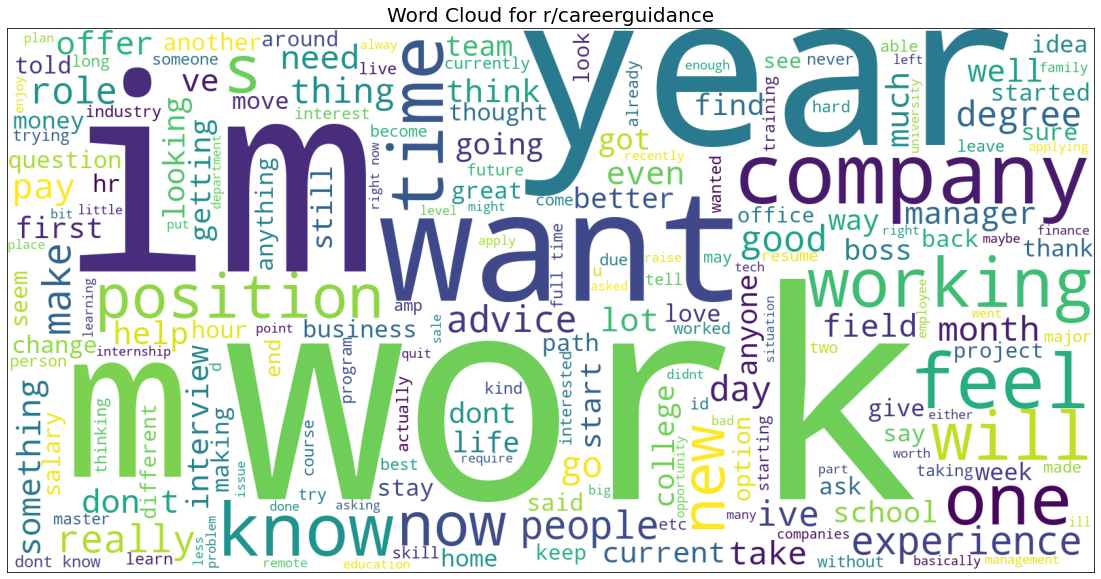

In [38]:
wordcloud = WordCloud(
    background_color="white",
    width=1600, height=800
).generate(' '.join(text_careerguidance.str.lower()))
plt.figure(figsize=(20,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('Word Cloud for r/careerguidance', size=20)
plt.imshow(wordcloud);

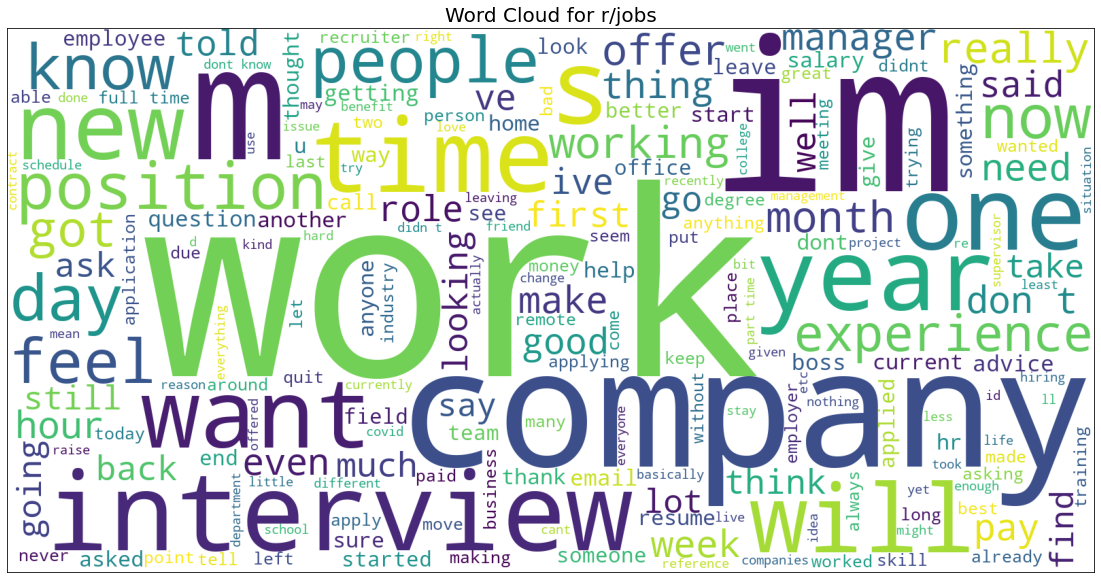

In [39]:
wordcloud = WordCloud(
    background_color="white",
    width=1600, height=800
).generate(' '.join(text_jobs.str.lower()))
plt.figure(figsize=(20,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('Word Cloud for r/jobs', size=20)
plt.imshow(wordcloud);

In [40]:
text_bothsubreddits = pd.concat(objs=[text_jobs,text_careerguidance])

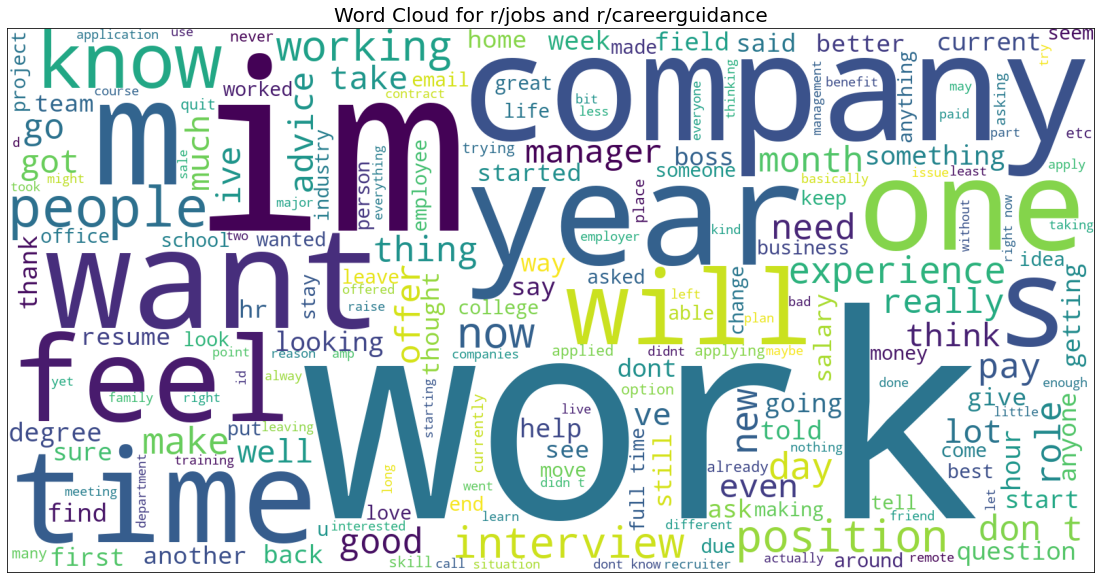

In [41]:
wordcloud = WordCloud(
    background_color="white",
    width=1600, height=800
).generate(' '.join(text_bothsubreddits.str.lower()))
plt.figure(figsize=(20,10))
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.title('Word Cloud for r/jobs and r/careerguidance', size=20)
plt.imshow(wordcloud);
plt.savefig('./images/wordcloud_jobs_careerguidance.png')

Word clouds are more decorative than effective in these cases, especially since there are a number of common top words between the two. We will review the counts in more detail below via sorted barplots.

[Back to top](#Notebook-organization)

#### Plots for `combined_text`

In [42]:
# instantiate for count vectorizer (bi-/tri-grams only)
cvec = CountVectorizer(
    stop_words=ENGLISH_STOP_WORDS,
    ngram_range=(2, 3)
)

In [43]:
# Set up dataframes for each subreddit
series_careerguidance = pd.DataFrame(
    cvec.fit_transform(
        df_combined[df_combined['subreddit_jobs'] == 0]['combined_text']
    ).toarray(),
    columns=cvec.get_feature_names()
).sum().sort_values(ascending=False)

series_jobs = pd.DataFrame(
    cvec.fit_transform(
        df_combined[df_combined['subreddit_jobs'] == 1]['combined_text']
    ).toarray(),
    columns=cvec.get_feature_names()
).sum().sort_values(ascending=False)

In [44]:
# visualize top common words
def words_barplot(data_series, title, figsize=(16,10), top_n=20, **kwargs):
    plt.figure(figsize=figsize)
    sns.barplot(
        y=data_series.head(top_n).index.values,
        x=data_series.head(top_n),
        color='khaki',
        **kwargs
    )
    plt.title(title)

In [59]:
# instantiate for count vectorizer (bi-/tri-grams only)
cvec = CountVectorizer(
    stop_words=ENGLISH_STOP_WORDS,
    ngram_range=(2, 3)
)
# Set up dataframes for each subreddit
series_careerguidance = pd.DataFrame(
    cvec.fit_transform(
        df_combined[df_combined['subreddit_jobs'] == 0]['combined_text']
    ).toarray(),
    columns=cvec.get_feature_names()
).sum().sort_values(ascending=False)

series_jobs = pd.DataFrame(
    cvec.fit_transform(
        df_combined[df_combined['subreddit_jobs'] == 1]['combined_text']
    ).toarray(),
    columns=cvec.get_feature_names()
).sum().sort_values(ascending=False)

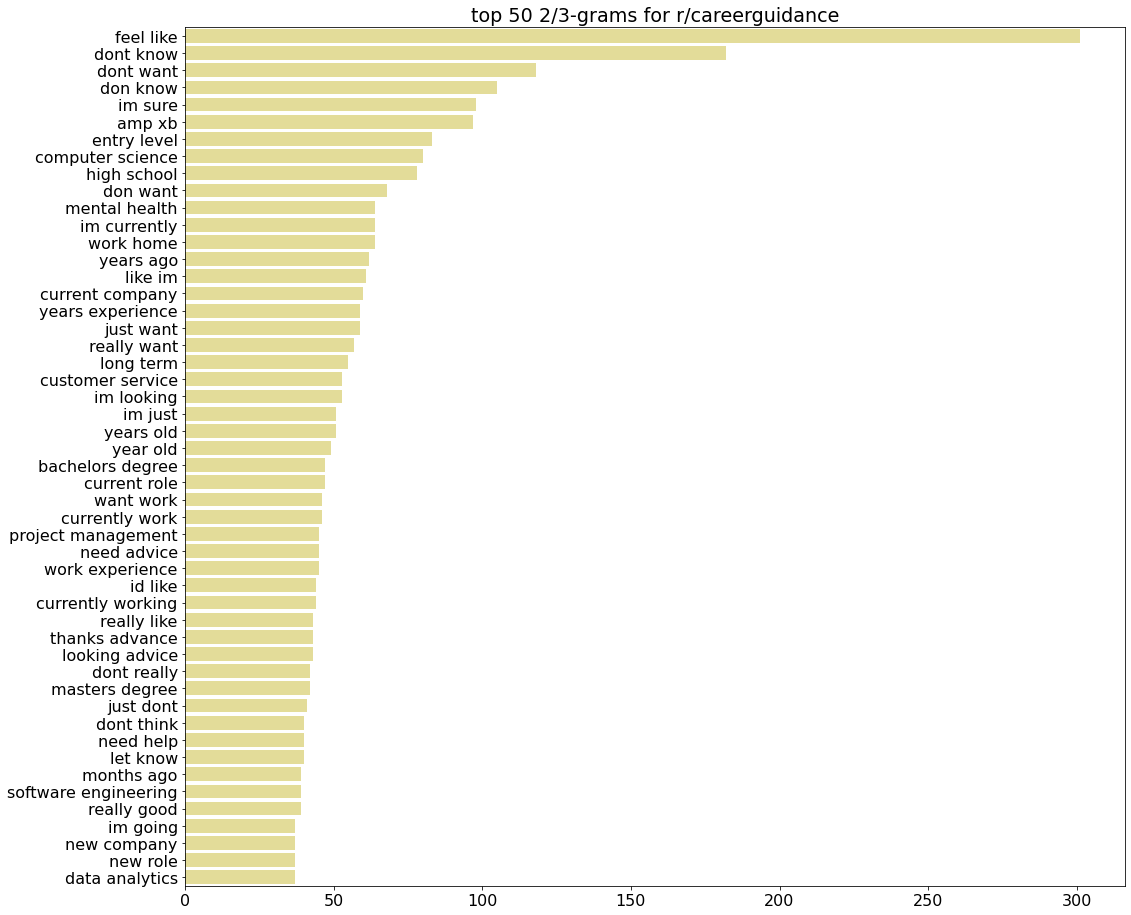

In [60]:
# plot and save
words_barplot(
    data_series=series_careerguidance,
    title='top 50 2/3-grams for r/careerguidance',
    figsize=(16,13),
    top_n=50
)
plt.tight_layout()
plt.savefig('./images/barplot_top50_2_3grams_careerguidance.png')

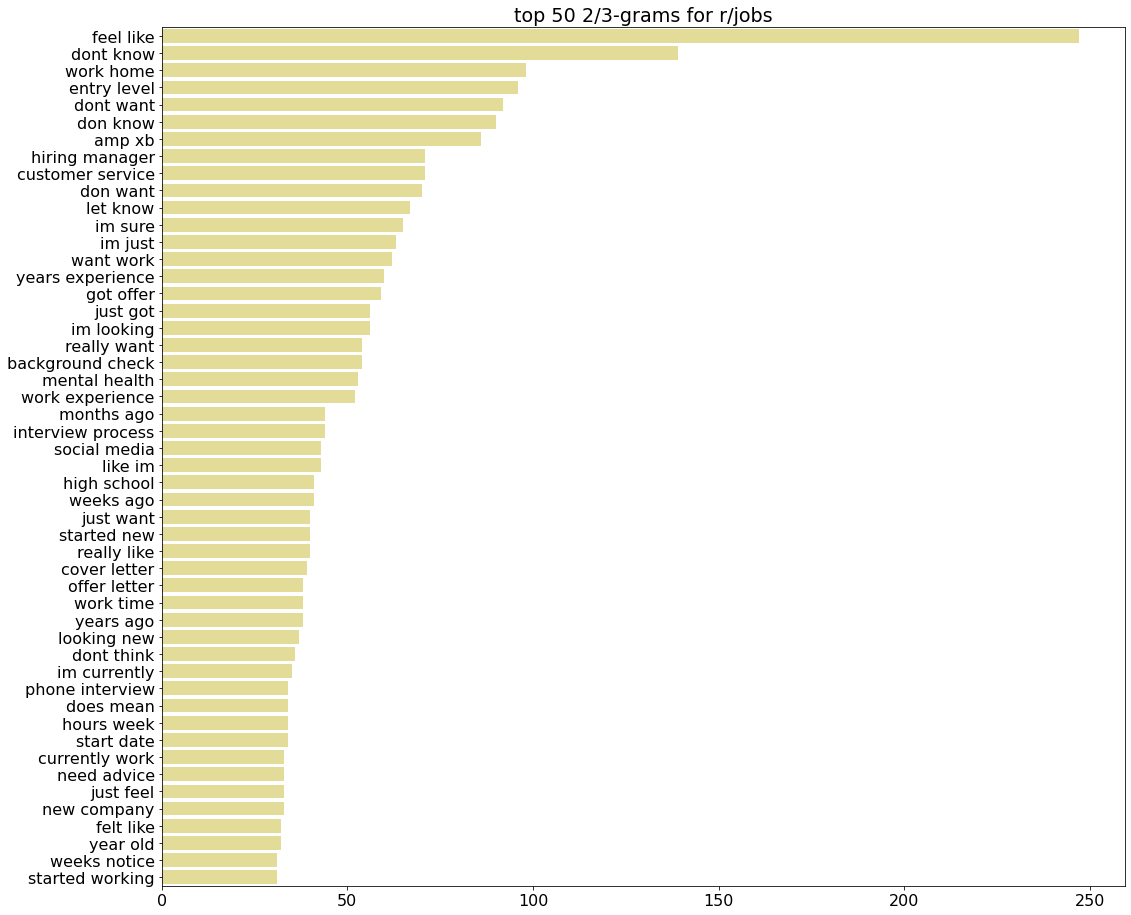

In [61]:
# plot and save
words_barplot(
    data_series=series_jobs,
    title='top 50 2/3-grams for r/jobs',
    figsize=(16,13),
    top_n=50
)
plt.tight_layout()
plt.savefig('./images/barplot_top50_2_3grams_jobs.png')

[Back to top](#Notebook-organization)

In [49]:
# instantiate for count vectorizer (unigrams to 5-grams)
cvec = CountVectorizer(
    stop_words=ENGLISH_STOP_WORDS,
    ngram_range=(1, 5)
)

# Set up dataframes for each subreddit
series_careerguidance = pd.DataFrame(
    cvec.fit_transform(
        df_combined[df_combined['subreddit_jobs'] == 0]['combined_text']
    ).toarray(),
    columns=cvec.get_feature_names()
).sum().sort_values(ascending=False)

series_jobs = pd.DataFrame(
    cvec.fit_transform(
        df_combined[df_combined['subreddit_jobs'] == 1]['combined_text']
    ).toarray(),
    columns=cvec.get_feature_names()
).sum().sort_values(ascending=False)

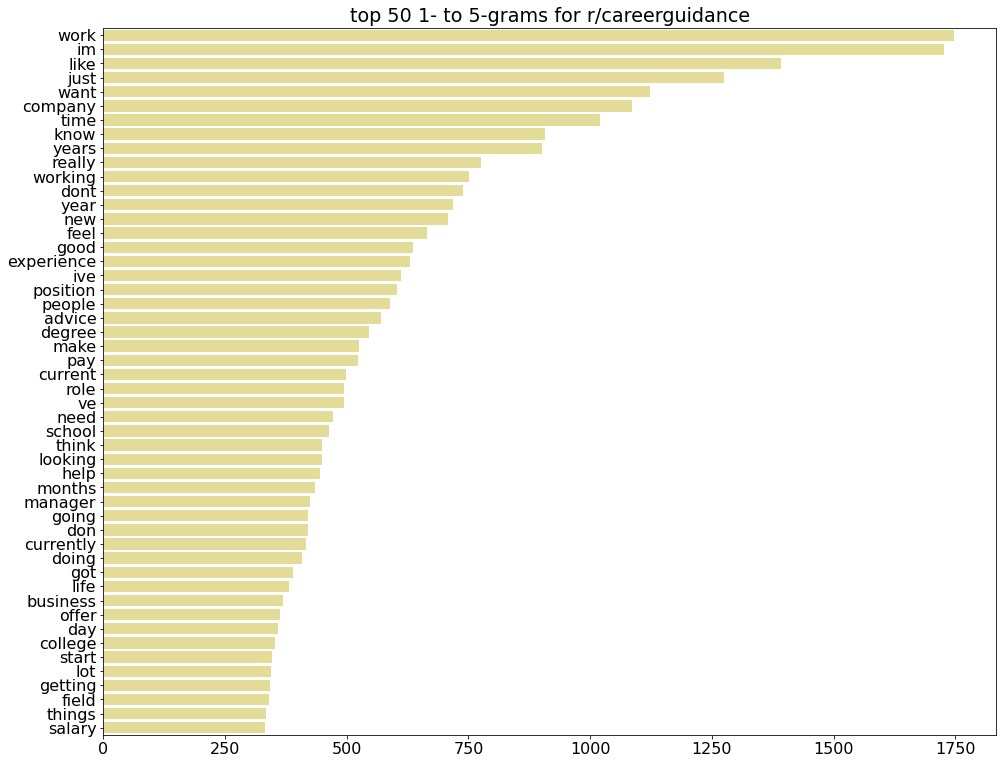

In [50]:
# plot and save
words_barplot(
    data_series=series_careerguidance,
    title='top 50 1- to 5-grams for r/careerguidance',
    figsize=(16,13),
    top_n=50
)
plt.savefig('./images/barplot_top50_1_5grams_careerguidance.png')

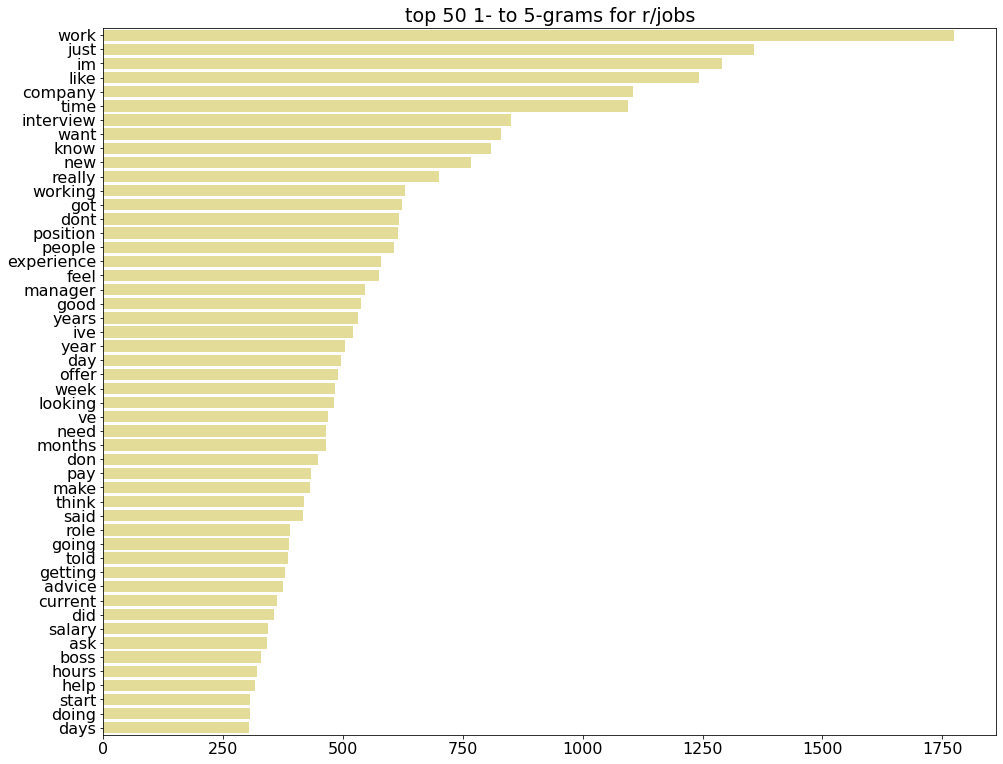

In [51]:
# plot and save
words_barplot(
    data_series=series_jobs,
    title='top 50 1- to 5-grams for r/jobs',
    figsize=(16,13),
    top_n=50
)
plt.savefig('./images/barplot_top50_1_5grams_jobs.png')

Prima facie, it appears bigrams and trigrams capture more dissimilar top common words between subreddits, which hints at higher predictive power where they do appear in text.

However, the common-ness of unigrams exceed bigrams and trigrams by far.

There is probably more cleaning one can do (e.g. typo correction, stemming, lemmatizing) but at this stage we see common words like "don" and phrases like "don know", "don want", that may be misinterpreted by a lemmatizer. Given more time, this is something we should come back to in the cleaning process.

As we extract these top 50 word/phrase barplots into a slide, I did not bother creating subplots.

[Back to top](#Notebook-organization)

### Export

In [52]:
df_combined.reset_index(inplace=True)

In [53]:
df_combined.drop(columns=['index'], inplace=True)

In [54]:
df_combined

,title,selftext,subreddit_jobs,combined_text
0,Got a offer at one of the first jobs I applied...,"30 years old, BA degree, lot of sales work his...",1,got a offer at one of the first i applied too...
1,How does educational history show up on a back...,Most of the time my resume will be discarded d...,1,how does educational history show up on a back...
2,I was about to quit then I got a bonus and a r...,"So long story short, been with my company for ...",1,i was about to quit then i got a bonus and a r...
3,What jobs do I qualify for with these skills?,Currently a rising sophomore in college so no ...,1,what do i qualify for with these skills? curr...
4,Age requirement?,How old do I have to be to get a job? Any job ...,1,age requirement? how old do i have to be to ge...
...,...,...,...,...
4701,I'm in a favorable negotiating position for th...,"I'm in a position that is OK, making about $80...",0,im in a favorable negotiating position for the...
4702,How to go back to college after years…need advice,[removed],0,how to go back to college after years…need adv...
4703,Is this a good career change resume summary?,"""Technical Sales Engineer with 2+ years of exp...",0,is this a good change resume summary? technic...
4704,"How Do Remote Jobs ""Work""?",So as someone who lives in a really small town...,0,how do remote work? so as someone who lives i...


In [55]:
# export to csv
df_combined.to_csv('./data/combined_data.csv')